## **Deep Learning Image Classification Model**

### **1 - Import Libraries**

Torch API

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchsummary import summary
from tqdm.notebook import tqdm

Data API

In [2]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import re
import requests

Install opendatasets package

In [3]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
import opendatasets as od

### **2 - Download the Data**

In [5]:
url = 'https://www.kaggle.com/trolukovich/apparel-images-dataset'

In [6]:
od.download(url)

Skipping, found downloaded files in "./apparel-images-dataset" (use force=True to force download)


### **3 - Get the Path of Images and the Labels (from directory name)**

In [7]:
def get_path_names(dir):
  images = []
  labels = []

  for path, subdir, files in os.walk(dir):
    for fname in files:
      image_path = os.path.join(path, fname)
      images.append(image_path)
      label = list(os.path.join(path).split('/')[2].split('_')[:])
      labels.append(label)

  return images, labels

images, labels = get_path_names('./apparel-images-dataset')

### **4 - Setup the Output Classes (to be used for encoding and decoding)**

In [8]:
classes = ['black',
           'blue',
           'brown',
           'green',
           'white',
           'red',
           'dress',
           'pants',
           'shorts',
           'shoes',
           'shirt']

### **5 - Define the Encoder and Decoder** (convert target to label and vice versa)

In [9]:
def encode(label, classes=classes):
  output = torch.zeros(11)
  for l in label:
    idx = classes.index(l)
    output[idx] = 1
  return output

def decode(output, threshold=0.5):
  label = []
  for i, n in enumerate(output):
    if (n >= threshold):
      label.append(classes[i])
  return ' '.join(label)

### **6 - Define Custom Dataset**

In [10]:
class MyDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    super().__init__()
    self.root_dir = root_dir
    self.transform = transform
    self.images, self.labels = get_path_names(root_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = Image.open(self.images[index])
    if self.transform:
      image = self.transform(image)
    label = self.labels[index]
    # print(label)
    return image, encode(label)


### **7 - Image Transformation**

In [11]:
imagenet_stats = ([0.485, 0.45, 0.406], [0.229, 0.224, 0.225])

In [12]:
transform = T.Compose([T.Resize(128),
                       T.RandomCrop(128),
                       T.RandomHorizontalFlip(),
                       T.RandomRotation(2),
                       T.ToTensor(),
                       T.Normalize(*imagenet_stats)]);

### **8 - Load Dataset**

In [13]:
dataset = MyDataset('./apparel-images-dataset', transform)
len(dataset)

11385

### **9 - Denormalization Function to Show the Actual Image**

Label:  blue shoes
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


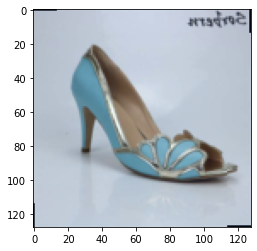

In [14]:
def denorm(image_tensors):
  return image_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_image(image, label):
  plt.imshow(denorm(image).permute(1,2,0))
  print("Label: ", decode(label))
  print(label)

show_image(*dataset[11380])

### **10 - Train-Validation Split**

In [15]:
val_size = int(0.15*len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(9678, 1707)

### **11 - Define DataLoaders**

In [16]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2)

### **12 - Define Utility Functions to load to device**

In [17]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [18]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

### **13 - Define Metrics**

In [19]:
def F_score(output, label, threshold=0.5, beta=1):
  output = output > threshold
  label = label > threshold

  TP = (output & label).sum(1).float()
  TN = (~output & ~label).sum(1).float()
  FP = (output & ~label).sum(1).float()
  FN = (~output & label).sum(1).float()

  precision = torch.mean(TP/(TP + FP + 1e-12))
  recall = torch.mean(TP/(TP + FN + 1e-12))
  F2 = (1 + beta**2)* precision * recall / (beta**2 * precision + recall + 1e-12)

  return F2.mean(0)


### **14 - Define Traning and Validation STEP Routines**

In [20]:
class MultiClassClassification(nn.Module):
  def train_step(self, batch):
    images, labels = batch
    output = self(images)
    loss = F.binary_cross_entropy(output, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    output = self(images)
    loss = F.binary_cross_entropy(output, labels)
    score = F_score(output, labels)
    return {'val_loss':loss.detach(), 'val_score':score.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_scores = [x['val_score'] for x in outputs]
    epoch_score = torch.stack(batch_scores).mean()
    return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_score']))

### **15 - Define Training and Validation Process**

In [21]:
def evaluate(model, val_dl):
  with torch.no_grad():
      model.eval()
      outputs = [model.validation_step(batch) for batch in val_dl]
      return model.validation_epoch_end(outputs)

def fit(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  # Optimizer
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

  for epoch in range(epochs):

    #Training
    model.train()
    train_losses = []
    # lrs = []

    for batch in tqdm(train_dl):
      loss = model.train_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Gradient Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

    # Validation
    result = evaluate(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    print(result)

    model.epoch_end(epoch, result)
    history.append(result)
            
  return history



### **16 - Model Creation**

In [22]:
# Conv Block
def conv_block(input_channels, output_channels, pool=False):
  layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)]

  if pool: layers.append(nn.MaxPool2d(4))

  return nn.Sequential(*layers)

In [23]:
# Project Model (ResNet15) based
class ProjectModel(MultiClassClassification):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    # input 3 x 128 x 128

    self.conv1 = conv_block(in_channels, 64)
    self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) # 64 x 128 x 128

    self.conv2 = conv_block(64, 128, pool=True) # 128 x 32 x 32
    self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 512, pool=True) # 512 x 8 x 8
    self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.conv4 = conv_block(512, 1024, pool=True) # 1024 x 2 x 2
    self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

    self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1024 x 1 x 1
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, num_classes))

  # Forward
  def forward(self, x):
    out = self.conv1(x)
    out = self.res1(out) + out
    out = self.conv2(out)
    out = self.res2(out) + out
    out = self.conv3(out)
    out = self.res3(out) + out
    out = self.conv4(out)
    out = self.res4(out) + out

    out = self.classifier(out)
    out = F.sigmoid(out)
    return out

In [24]:
device = get_default_device()
model = to_device(ProjectModel(3, len(classes)), device)
model

ProjectModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mod

In [25]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          36,928
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
        MaxPool2d-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 128,

/Users/tonmoydey/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### **17 - Training the Model**

In [26]:
#  Hyperparameters
epochs = 3
lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [27]:
# Training

history = fit(epochs, lr, model, train_dl, val_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)


{'val_loss': 0.1452827751636505, 'val_score': 0.8190315365791321, 'train_loss': 0.21707668900489807}
Epoch [0], train_loss: 0.2171, val_loss: 0.1453, val_score: 0.8190



{'val_loss': 0.10721645504236221, 'val_score': 0.8889080882072449, 'train_loss': 0.12184283137321472}
Epoch [1], train_loss: 0.1218, val_loss: 0.1072, val_score: 0.8889



{'val_loss': 0.0938473716378212, 'val_score': 0.908584475517273, 'train_loss': 0.10529273748397827}
Epoch [2], train_loss: 0.1053, val_loss: 0.0938, val_score: 0.9086


### **18 - Plotting the Metrics**

In [28]:
def plot_scores(history):
  scores = [x['val_score'] for x in history]
  plt.plot(scores)
  plt.xlabel('epoch')
  plt.ylabel('score')
  plt.title('F1 Score Vs. Epoch')
  plt.show()

def plot_losses(history):
  val_losses = [x['val_loss'] for x in history]
  train_losses = [x['train_loss'] for x in history]
  plt.plot(val_losses, '-rx', label='Validation')
  plt.plot(train_losses, '-bx', label='Train')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title('Loss Vs. Epoch')
  plt.show()

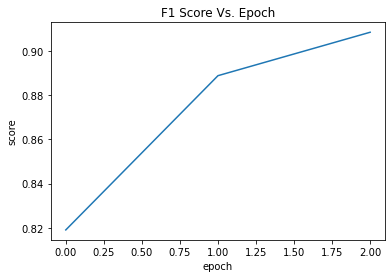

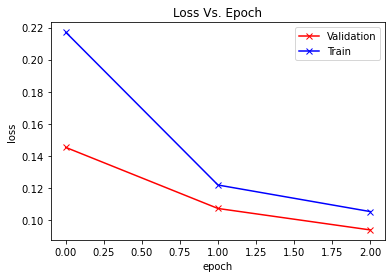

In [29]:
plot_scores(history)
plot_losses(history)

### **19 - Testing the Model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction Label:  blue shirt
Label:  blue shirt
tensor([1.6171e-03, 9.9798e-01, 6.5156e-06, 3.2483e-03, 5.6052e-06, 3.7909e-07,
        2.8269e-04, 9.2780e-02, 1.2908e-02, 1.0480e-03, 9.0414e-01],
       grad_fn=<SelectBackward>)


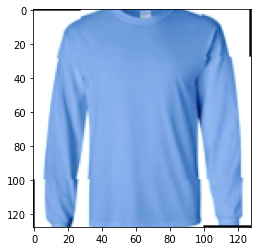

In [33]:
def predict_single(image):
  x = image.unsqueeze(0)
  x = to_device(x, device)
  preds = model(x)
  prediction = preds[0]
#   print('Output Tensor: ', preds)
#   print('Prediction Tensor: ', prediction)
  print('Prediction Label: ', decode(prediction))

  show_image(image, prediction)

predict_single(val_ds[80][0])